In [102]:
# Install dependencies
%pip install pandas
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pandas in c:\users\charl\appdata\local\programs\python\python313\lib\site-packages (2.2.3)




[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [103]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
import numpy as np

In [104]:
# Import data
data = pd.read_csv("bank_transactions_data_2.csv")

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [105]:
# Check for missing values: No missing values
print("Missing values:\n", data.isnull().sum())

Missing values:
 TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
dtype: int64


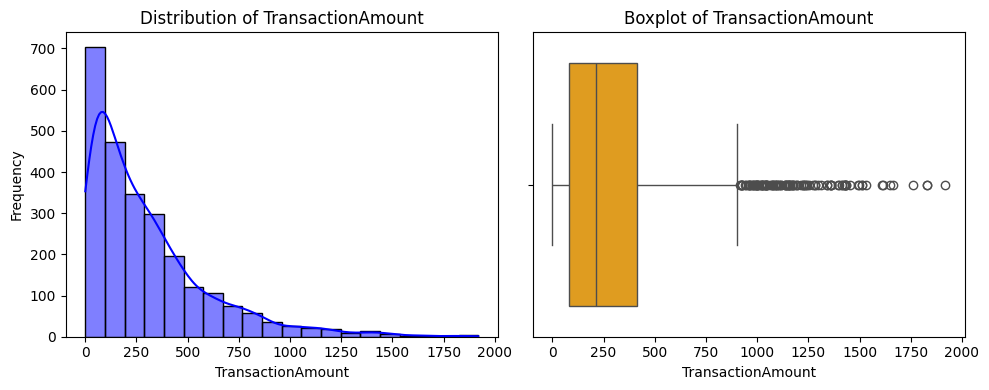

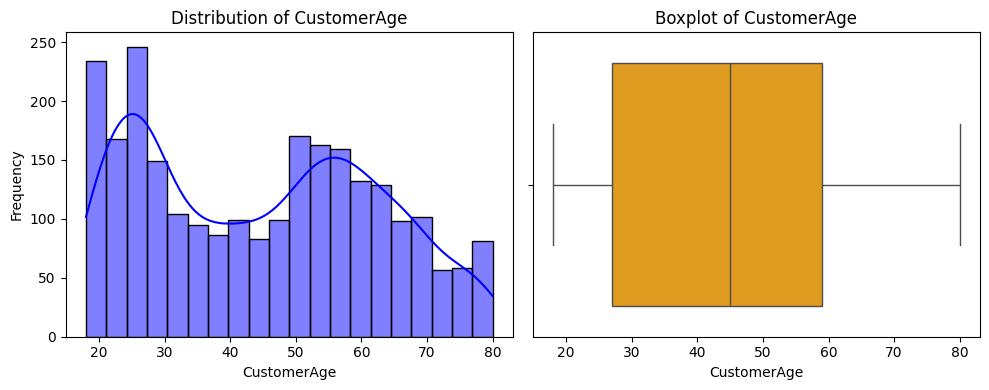

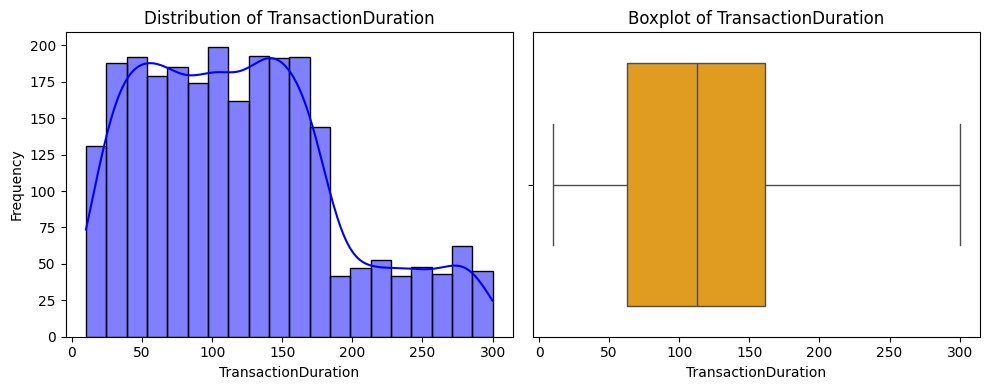

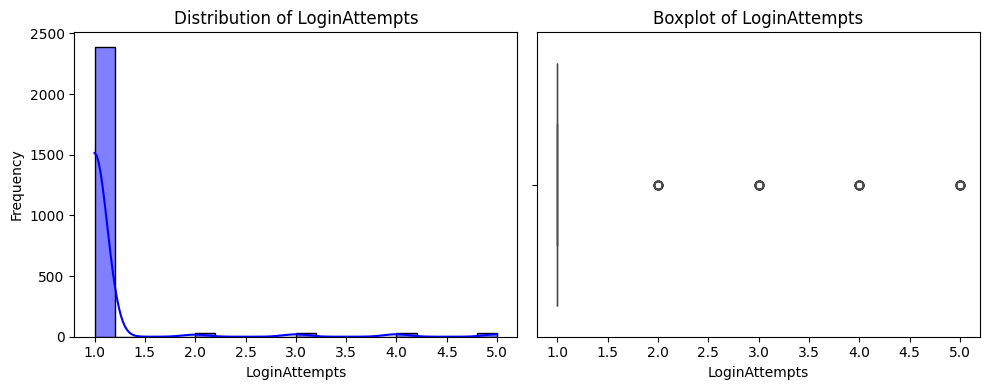

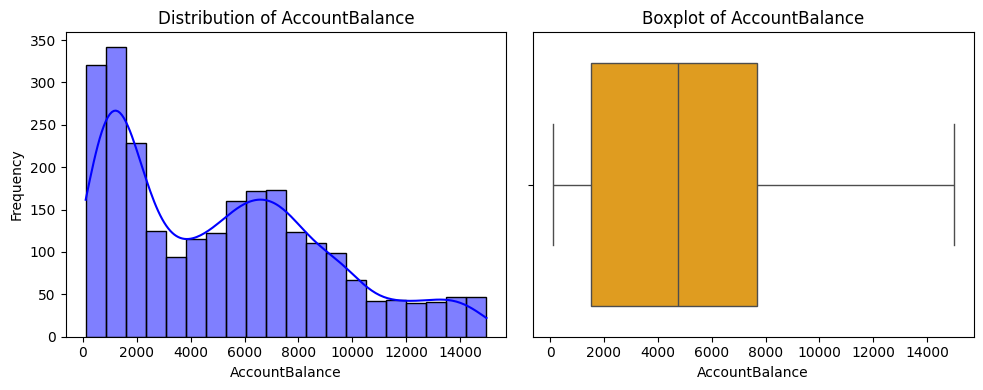

In [106]:
# Data visualisation (univariate analysis) - Numeric columns

# Identify numeric and categorical columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

# Plot univariate graphs
# For numeric columns: Histograms and Boxplots
for col in numeric_cols:
    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data[col], kde=True, bins=20, color='blue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col], color='orange')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()

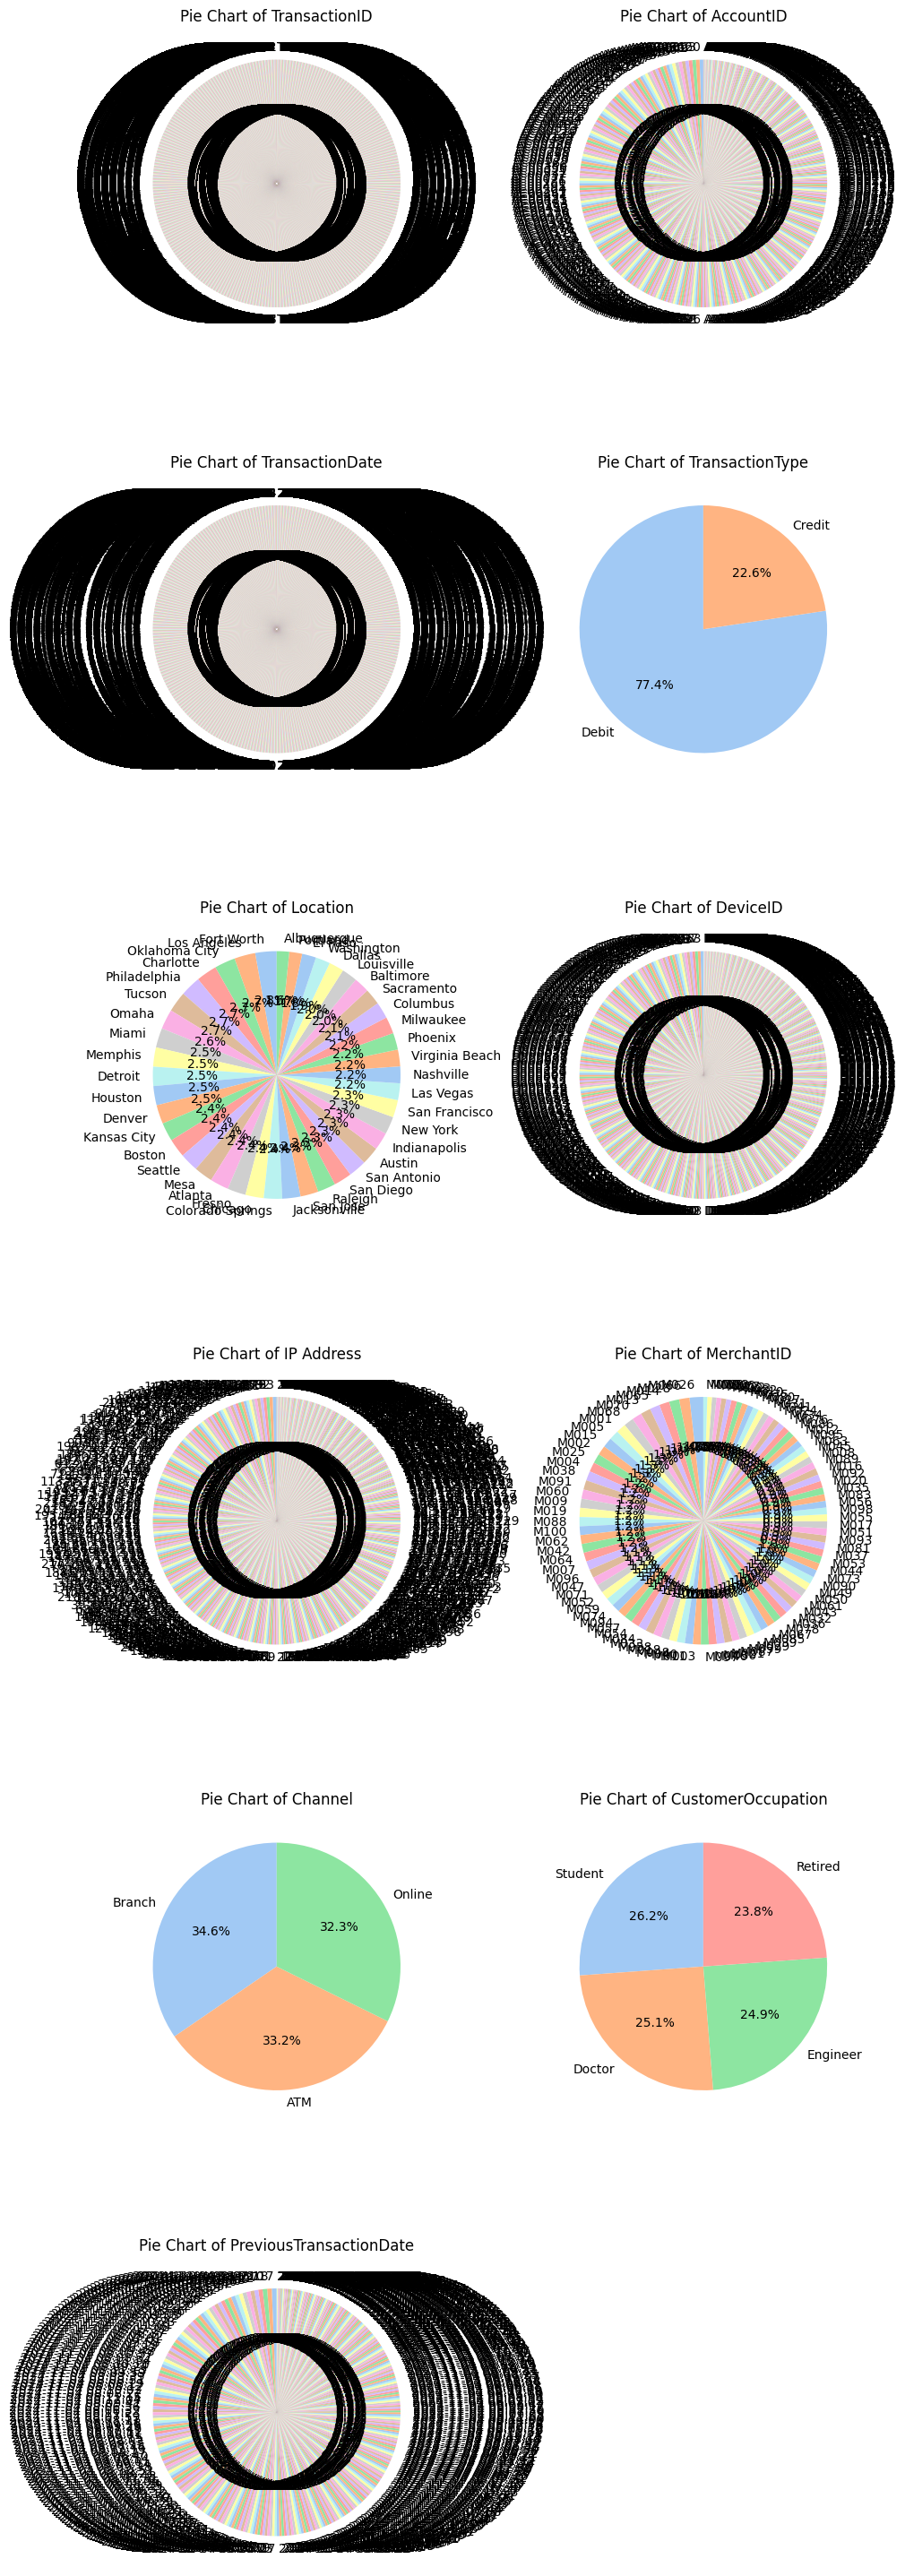

In [107]:
# Data visualisation (univariate analysis) - Categorical columns

# Define the number of columns you want per row
num_cols = 2  # Adjust this based on your preference
num_rows = -(-len(categorical_cols) // num_cols)  # Calculate rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))

# Flatten axes array if there's more than one row
axes = axes.flatten() if num_rows > 1 else [axes]

for i, col in enumerate(categorical_cols):
    data[col].value_counts().plot.pie(
        ax=axes[i],
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('pastel')
    )
    axes[i].set_title(f'Pie Chart of {col}', fontsize=12)
    axes[i].set_ylabel('')  # Remove default y-axis label

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



Correlation Matrix:
                     TransactionAmount  CustomerAge  TransactionDuration  \
TransactionAmount             1.000000    -0.025616             0.004359   
CustomerAge                  -0.025616     1.000000            -0.017936   
TransactionDuration           0.004359    -0.017936             1.000000   
LoginAttempts                -0.008445     0.007653             0.032639   
AccountBalance               -0.025165     0.319942             0.005577   

                     LoginAttempts  AccountBalance  
TransactionAmount        -0.008445       -0.025165  
CustomerAge               0.007653        0.319942  
TransactionDuration       0.032639        0.005577  
LoginAttempts             1.000000        0.014999  
AccountBalance            0.014999        1.000000  


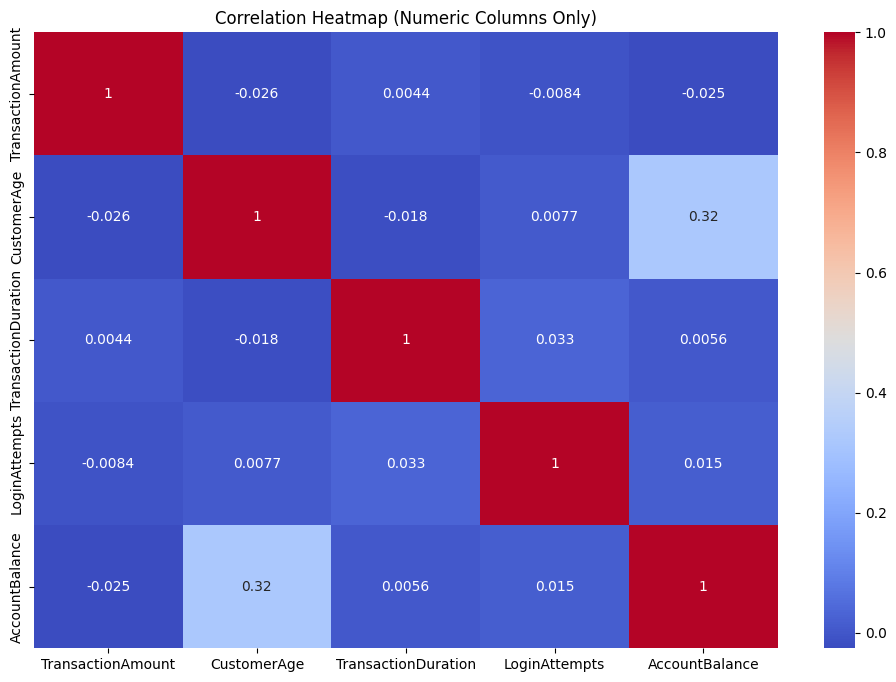

In [108]:
# Data visualisation (HEATMAP)
# Select only numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix for numeric data only
correlation_matrix = numeric_data.corr()

# Verify the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Numeric Columns Only)')
plt.show()



In [112]:
# Data Preprocessing
original_data = data.copy()

# Handle categorical data
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data['PreviousTransactionDate'] = pd.to_datetime(data['PreviousTransactionDate'])

# Drop columns that are not needed for the model
data = data.drop(columns=['TransactionID', 'AccountID', 'DeviceID', 'IP Address', 'MerchantID'])

# Preprocessing: Handle datetime columns
data['TimeSinceLastTransaction'] = (data['TransactionDate'] - data['PreviousTransactionDate']).dt.total_seconds()

# Identify numeric and categorical columns
numeric_cols = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'CustomerAge', 'TimeSinceLastTransaction']
categorical_cols = ['TransactionType', 'Location', 'Channel', 'CustomerOccupation']

# Normalize numeric columns
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

# Descriptive Statistics
print("Descriptive Statistics:")
print(data.describe())

# Initialize Fraud column
data['Fraud'] = False

print("Processed Data:")
print(data.head())
print(data.info())

Descriptive Statistics:
       TransactionAmount                TransactionDate  TransactionType  \
count       2.512000e+03                           2512      2512.000000   
mean       -7.071484e-18  2023-07-05 20:32:10.826433024         0.773885   
min        -1.018657e+00            2023-01-02 16:00:06         0.000000   
25%        -7.390118e-01  2023-04-03 16:22:05.750000128         1.000000   
50%        -2.961881e-01     2023-07-07 17:49:43.500000         1.000000   
75%         4.006114e-01     2023-10-06 18:40:53.500000         1.000000   
max         5.555266e+00            2024-01-01 18:21:50         1.000000   
std         1.000199e+00                            NaN         0.418398   

          Location      Channel  CustomerAge  CustomerOccupation  \
count  2512.000000  2512.000000  2512.000000         2512.000000   
mean     21.032643     0.991242     0.000000            1.510350   
min       0.000000     0.000000    -1.499493            0.000000   
25%      11.000000 

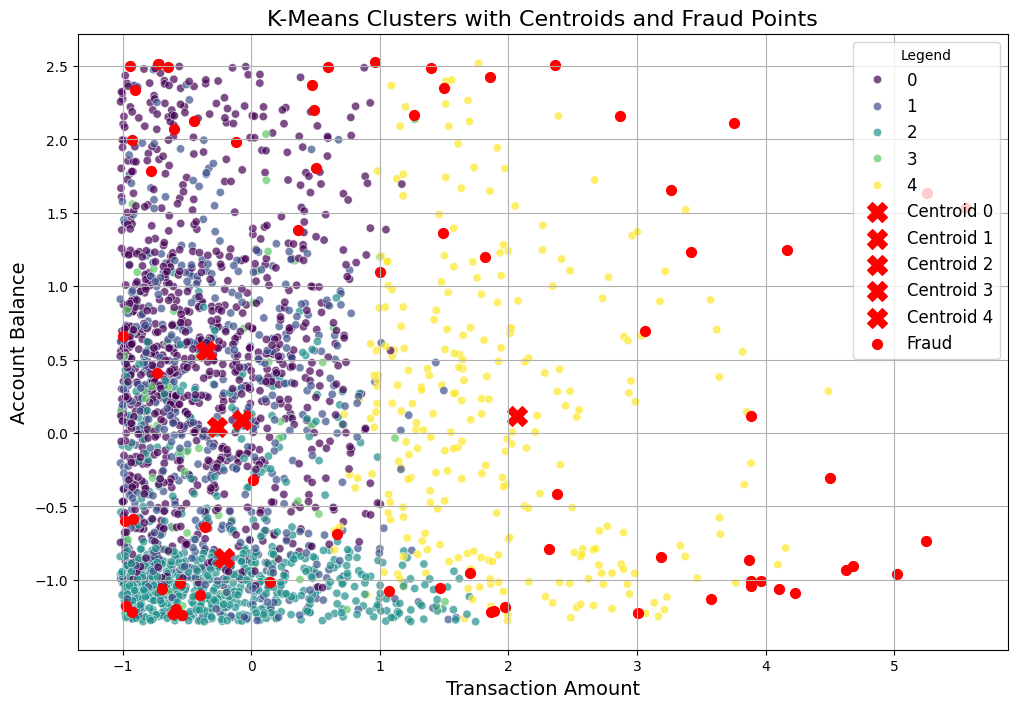

Total Fraudulent Transactions Detected (Using K Means clustering): 70


In [119]:
# K-Means Clustering - Identifies anomalies based on distance from centroids

# Perform K-Means clustering
n_clusters = 5  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(data[numeric_cols])
data['KMeans_Cluster'] = kmeans_labels

# Calculate centroids
centroids = kmeans.cluster_centers_

# Compute distances from centroids
distances = np.linalg.norm(data[numeric_cols].values - centroids[kmeans_labels], axis=1)
data['KMeans_Distance'] = distances

# Set fraud threshold: Mean + 2 * Standard Deviation
threshold = distances.mean() + 2 * distances.std()
data['Fraud'] = distances > threshold  # Only one fraud column needed

# Transform centroids back to original scale
centroids_original = scaler.inverse_transform(centroids)

# Scatterplot for two features with clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=data['TransactionAmount'],
    y=data['AccountBalance'],
    hue=data['KMeans_Cluster'],
    palette='viridis',
    alpha=0.7,
    legend='full'
)

# Overlay centroids on the scatterplot
for i, centroid in enumerate(centroids_original):
    plt.scatter(
        centroid[numeric_cols.index('TransactionAmount')],
        centroid[numeric_cols.index('AccountBalance')],
        color='red',
        marker='X',
        s=200,
        label=f'Centroid {i}'
    )

# Highlight fraud points
fraud_points = data[data['Fraud']]
plt.scatter(
    fraud_points['TransactionAmount'],
    fraud_points['AccountBalance'],
    color='red',
    marker='o',
    s=50,
    label='Fraud'
)

plt.title('K-Means Clusters with Centroids and Fraud Points', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Account Balance', fontsize=14)
plt.legend(title='Legend', fontsize=12)
plt.grid(True)
plt.show()

# Print summary of fraud points
total_fraud_points = data['Fraud'].sum()
print(f"Total Fraudulent Transactions Detected (Using K Means clustering): {total_fraud_points}")

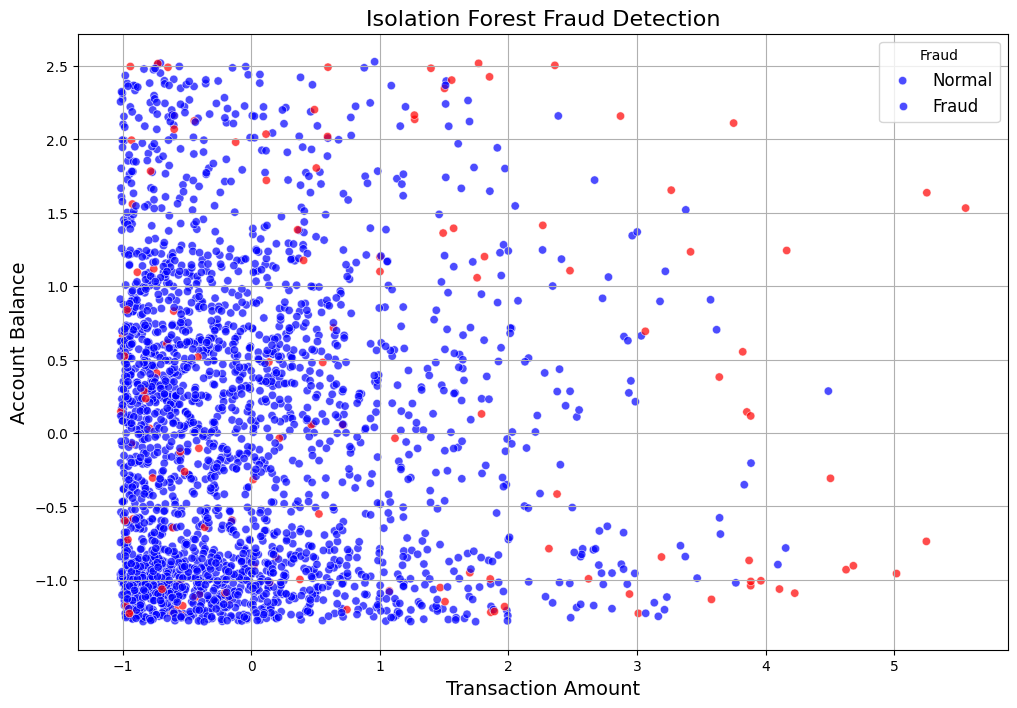

Total Fraudulent Transactions Detected (using isolation forest): 126


In [120]:
# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
features = data.drop(columns=['Fraud', 'TransactionDate', 'PreviousTransactionDate']).columns
data["IsoForest_Fraud"] = iso_forest.fit_predict(data[features])
data["IsoForest_Fraud"] = data["IsoForest_Fraud"].map({1: 0, -1: 1})
total_iso_fraud_points = data['IsoForest_Fraud'].sum()
data['Fraud'] |= data['IsoForest_Fraud']

# Scatterplot to visualize fraud points
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=data['TransactionAmount'],
    y=data['AccountBalance'],
    hue=data['IsoForest_Fraud'],
    palette={True: 'red', False: 'blue'},
    alpha=0.7
)
plt.title('Isolation Forest Fraud Detection', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Account Balance', fontsize=14)
plt.legend(title='Fraud', labels=['Normal', 'Fraud'], fontsize=12)
plt.grid(True)
plt.show()

print(f"Total Fraudulent Transactions Detected (using isolation forest): {total_iso_fraud_points}")


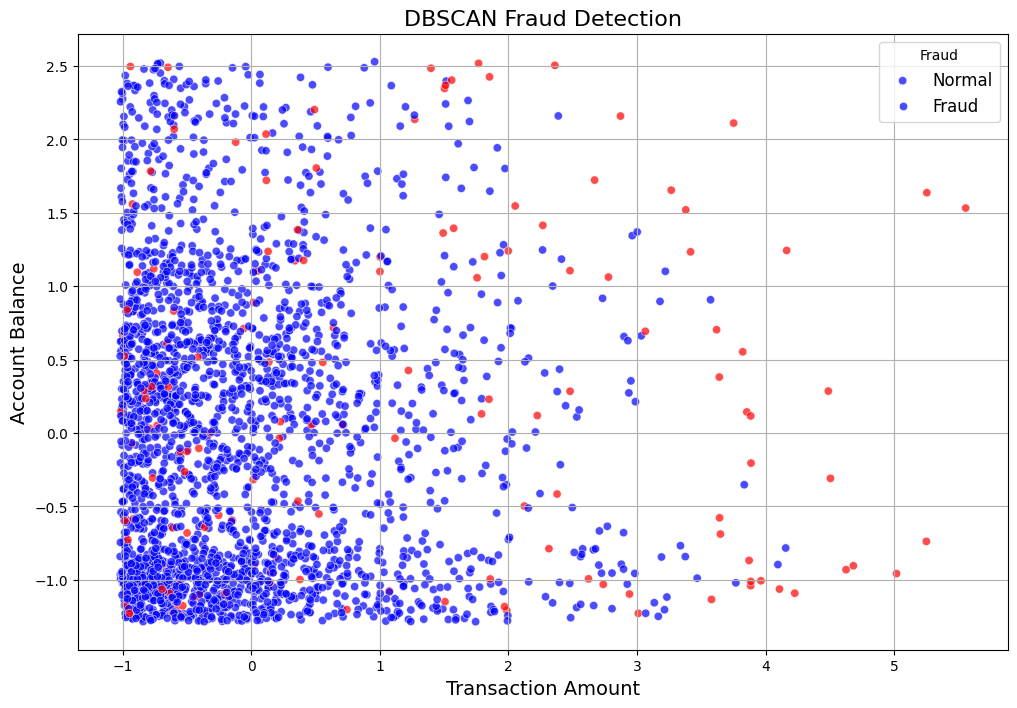

Total Fraudulent Transactions Detected by DBSCAN: 153


In [121]:
#DBSCAN Analysis

features = data.drop(columns=['Fraud', 'TransactionDate', 'PreviousTransactionDate']).columns
dbscan = DBSCAN(eps=3, min_samples=8)  # Adjust eps and min_samples as needed
dbscan_labels = dbscan.fit_predict(data[features])
data['DBSCAN_Cluster'] = dbscan_labels
data['DBSCAN_Fraud'] = data['DBSCAN_Cluster'] == -1
total_dbscan_fraud_points = data['DBSCAN_Fraud'].sum()
data['Fraud'] |= data['DBSCAN_Fraud']

# Scatterplot for DBSCAN fraud detection
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=data['TransactionAmount'],
    y=data['AccountBalance'],
    hue=data['DBSCAN_Fraud'],
    palette={True: 'red', False: 'blue'},
    alpha=0.7
)
plt.title('DBSCAN Fraud Detection', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Account Balance', fontsize=14)
plt.legend(title='Fraud', labels=['Normal', 'Fraud'], fontsize=12)
plt.grid(True)
plt.show()

print(f"Total Fraudulent Transactions Detected by DBSCAN: {total_dbscan_fraud_points}")

In [122]:
total_fraud_points = data['Fraud'].sum()
print(f"Total Fraudulent Transactions Detected: {total_fraud_points}")

original_data['Fraud'] = data['Fraud']
original_data.to_csv("original_data_with_fraud.csv", index=False)
print("Original data with Fraud column saved as 'original_data_with_fraud.csv'")

Total Fraudulent Transactions Detected: 168
Original data with Fraud column saved as 'original_data_with_fraud.csv'


In [ ]:
# Split data (training, development, test)